# Hudson Valley Gentrification and Changes in Farming

## Notebook 3: USDA Agriculture Census data

In [493]:
import pandas as pd
import requests
import os
import geopandas as gpd

In [494]:
api_key_nass = os.getenv("QUICK_STATS_API_KEY")

In [495]:
gdf_zipcodes = gpd.read_file("data/zctas_core.geojson")

In [496]:
gdf_zipcodes.head(1)

,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,12577,12577,B5,G6350,S,19999901,169531,+41.4214832,-074.1168149,"POLYGON ((288257.82 142661.193, 288349.37 1426..."


In [497]:
zipcodes = gdf_zipcodes.ZCTA5CE20.values

In [498]:
zipcodes

array(['12577', '10953', '10930', '12158', '10990', '12054', '10950',
       '12143', '12529', '12586', '12589', '10980', '10509', '12545',
       '12543', '12582', '12729', '10933', '12518', '06757', '06068',
       '06784', '06069', '06039', '12123', '12169', '12427', '12015',
       '12423', '12444', '01254', '01237', '01258', '18458', '18405',
       '18461', '18417', '18415', '18435', '18336', '18340', '01267',
       '01230', '01201', '01266', '07422', '07827', '07456', '07418',
       '07462', '07461', '07421', '12590', '12062', '12168', '12018',
       '12468', '12482', '12042', '12569', '12424', '12473', '12553',
       '10969', '12460', '10975', '12538', '12138', '12153', '12061',
       '12603', '12413', '12051', '12480', '12439', '12485', '12463',
       '12581', '12734', '12448', '12787', '12428', '12726', '12762',
       '12751', '12421', '12513', '12173', '12195', '12498', '12490',
       '12457', '12477', '12791', '12741', '12776', '12733', '12481',
       '12494', '127

## Download Economics and Demographics sectors from Agriculture Census and identify relevant variables

In [499]:
source_desc = "CENSUS"
sector_desc = ["Economics", "Demographics"]
group_desc = ['EXPENSES','FARMS & LAND & ASSETS','INCOME','PRODUCERS']
# These are the columns, in order, that (within a given sector) sequentially identify variables at any given level
group_cols = ["group_desc","commodity_desc", "class_desc", "prodn_practice_desc", "statisticcat_desc", "unit_desc","domain_desc","domaincat_desc"]

### Check whether there are fewer than 50,000 results at each specified year/level/sector

In [500]:
num_results = []
for year in ["2017","2022"]:
    for level in ["ZIP CODE", 'COUNTY']:
        for sector in sector_desc:
            r = requests.get(url=f'https://quickstats.nass.usda.gov/api/get_counts/?key={api_key_nass}', params={"sector_desc": sector, 
                                                                                                            "year": year, 
                                                                                                            "state_fips_code": "36", 
                                                                                                            "agg_level_desc": level}).json()
            num_results.append((year, level, sector, r['count']))

In [501]:
num_results

[('2017', 'ZIP CODE', 'Economics', 24414),
 ('2017', 'ZIP CODE', 'Demographics', 19578),
 ('2017', 'COUNTY', 'Economics', 24958),
 ('2017', 'COUNTY', 'Demographics', 17316),
 ('2022', 'ZIP CODE', 'Economics', 23609),
 ('2022', 'ZIP CODE', 'Demographics', 18113),
 ('2022', 'COUNTY', 'Economics', 24697),
 ('2022', 'COUNTY', 'Demographics', 13755)]

### Perform API calls for specified year/aggregation/sector; store results and transform into dataframes

In [502]:
ag_census_results = {}
for year in ["2017","2022"]:
    ag_census_results[year] = {}
    for level in ["zip code", 'county']:
        ag_census_results[year][level] = {}
        for sector in sector_desc:
            r = requests.get(url=f"https://quickstats.nass.usda.gov/api/api_GET/?key={api_key_nass}", 
                            params={"sector_desc": sector, 
                                    "year": year, 
                                    "state_fips_code": "36", 
                                    "agg_level_desc": level}).json()
            ag_census_results[year][level][sector] = r

In [503]:
for year in ["2017","2022"]:
    for level in ["zip code", 'county']:
        for sector in sector_desc:
            ag_census_results[year][level][sector]['df'] = pd.DataFrame.from_dict(ag_census_results[year][level][sector]['data'])

In [504]:
ag_census_results['2017']['county']['Economics']['df'].group_desc.unique()

array(['ENERGY', 'EXPENSES', 'FARMS & LAND & ASSETS', 'INCOME'],
      dtype=object)

In [505]:
for col in ag_census_results['2017']['county']['Economics']['df'].groupby(group_cols).size().reset_index().drop(0, axis=1).columns:
    print(col)
    print(ag_census_results['2017']['county']['Economics']['df'].groupby(group_cols).size().reset_index().drop(0, axis=1)[col].unique())

group_desc
['ENERGY' 'EXPENSES' 'FARMS & LAND & ASSETS' 'INCOME']
commodity_desc
['ENERGY' 'AG SERVICES' 'ANIMAL TOTALS' 'CHEMICAL TOTALS' 'DEPRECIATION'
 'EXPENSE TOTALS' 'FEED' 'FERTILIZER TOTALS' 'FUELS' 'INTEREST' 'LABOR'
 'RENT' 'SEEDS' 'SEEDS & PLANTS TOTALS' 'SUPPLIES & REPAIRS' 'TAXES'
 'AG LAND' 'FARM OPERATIONS' 'GOVT PROGRAMS' 'LAND AREA'
 'MACHINERY TOTALS' 'MACHINERY, OTHER' 'PRACTICES' 'SELF PROPELLED'
 'TRACTORS' 'TRUCKS' 'CCC LOANS' 'COMMODITY TOTALS' 'INCOME, FARM-RELATED'
 'INCOME, NET CASH FARM']
class_desc
['RENEWABLE, HARVEST BIOMASS FOR PRODUCTION'
 'CUSTOM SERVICES FOR LIVESTOCK, INCL MEDICAL SUPPLIES & VETERINARY'
 'CUSTOMWORK' 'MACHINERY RENTAL' 'OTHER' 'UTILITIES' '(EXCL BREEDING)'
 'ALL CLASSES' 'BREEDING' 'OPERATING' 'OPERATING, PAID BY LANDLORD'
 'INCL LIME & SOIL CONDITIONERS' 'INCL LUBRICANTS' 'NON-REAL ESTATE'
 'REAL ESTATE' 'CONTRACT' 'HIRED' 'HIRED, GE 150 DAYS'
 'HIRED, LT 150 DAYS' 'MIGRANT' 'UNPAID' 'CASH, CROPLAND'
 'CASH, LAND & BUILDINGS' 'CASH, 

In [506]:
for col in ag_census_results['2017']['county']['Demographics']['df'].groupby(group_cols).size().reset_index().drop(0, axis=1).columns:
    print(col)
    print(ag_census_results['2017']['county']['Demographics']['df'].groupby(group_cols).size().reset_index().drop(0, axis=1)[col].unique())

group_desc
['ANIMAL TOTALS' 'AQUACULTURE' 'CROP TOTALS' 'DAIRY' 'EXPENSES'
 'FARMS & LAND & ASSETS' 'FIELD CROPS' 'FRUIT & TREE NUTS' 'HORTICULTURE'
 'INCOME' 'LIVESTOCK' 'POULTRY' 'PRODUCERS' 'SPECIALTY' 'VEGETABLES']
commodity_desc
['ANIMAL TOTALS' 'AQUACULTURE TOTALS' 'CROP TOTALS' 'MILK'
 'EXPENSE TOTALS' 'LABOR' 'AG LAND' 'FARM OPERATIONS' 'INTERNET'
 'PRACTICES' 'BARLEY' 'CORN' 'FIELD CROPS, OTHER' 'GRAIN' 'HAY & HAYLAGE'
 'OATS' 'SOYBEANS' 'WHEAT' 'APPLES' 'FRUIT & TREE NUT TOTALS' 'GRAPES'
 'PEACHES' 'CUT CHRISTMAS TREES'
 'CUT CHRISTMAS TREES & SHORT TERM WOODY TREES' 'HORTICULTURE TOTALS'
 'NURSERY TOTALS' 'SOD' 'COMMODITY TOTALS' 'GOVT PROGRAMS'
 'INCOME, FARM-RELATED' 'INCOME, NET CASH FARM' 'CATTLE' 'GOATS' 'HOGS'
 'SHEEP' 'SHEEP & GOATS TOTALS' 'CHICKENS' 'POULTRY TOTALS' 'TURKEYS'
 'PRODUCERS' 'PRODUCERS, PRINCIPAL' 'EQUINE' 'SPECIALTY ANIMAL TOTALS'
 'POTATOES' 'SQUASH' 'SWEET CORN' 'VEGETABLE TOTALS']
class_desc
['INCL PRODUCTS' 'ALL CLASSES' 'OPERATING' 'HIRED'
 '(EXC

In [507]:
# save raw data to CSVs
for year in ["2017","2022"]:
    for level in ["zip code", 'county']:
        for sector in sector_desc:
            ag_census_results[year][level][sector]['df'].to_csv(f"data/ag_census_{"".join(level.split(" "))}_{year}_{sector}.csv", index=False, encoding='utf-8')

In [508]:
# save variables to CSVs
for year in ["2017","2022"]:
    for level in ["zip code", 'county']:
        for sector in sector_desc:
            df = ag_census_results[year][level][sector]['df'].groupby(group_cols).size().reset_index().drop(0, axis=1)
            df.to_csv(f"data/ag_census_vars/ag_census_{"".join(level.split(" "))}_{year}_{sector}_variables.csv", index=False, encoding='utf-8')

Select relevant variables and prepare data for analysis

In [509]:
# Make separate dataframe for each universe and year

econ2017_zipcode_df = ag_census_results['2017']['zip code']['Economics']['df']
econ2022_zipcode_df = ag_census_results['2022']['zip code']['Economics']['df']
econ2017_county_df = ag_census_results['2017']['county']['Economics']['df']
econ2022_county_df = ag_census_results['2022']['county']['Economics']['df']

demog2017_zipcode_df = ag_census_results['2017']['zip code']['Demographics']['df']
demog2022_zipcode_df = ag_census_results['2022']['zip code']['Demographics']['df']
demog2017_county_df = ag_census_results['2017']['county']['Demographics']['df']
demog2022_county_df = ag_census_results['2022']['county']['Demographics']['df']

In [510]:
# Select just variables that I want to include in my study

econ2017_zipcode_df_subset = econ2017_zipcode_df.query("group_desc in ['FARMS & LAND & ASSETS','INCOME'] and commodity_desc in ['AG LAND','COMMODITY TOTALS'] and class_desc in ['CROPLAND, HARVESTED','ALL CLASSES'] and prodn_practice_desc != 'ORGANIC'").copy()
econ2022_zipcode_df_subset = econ2022_zipcode_df.query("group_desc in ['FARMS & LAND & ASSETS','INCOME'] and commodity_desc in ['AG LAND','COMMODITY TOTALS'] and class_desc in ['CROPLAND, HARVESTED','ALL CLASSES'] and prodn_practice_desc != 'ORGANIC'").copy()

In [511]:
# Select just variables that I want to include in my study

demog2017_zipcode_df_subset = demog2017_zipcode_df.query("domain_desc == 'TENURE' or prodn_practice_desc == 'PRIMARY OCCUPATION, FARMING'").copy()
demog2022_zipcode_df_subset = demog2022_zipcode_df.query("domain_desc == 'TENURE' or prodn_practice_desc == 'PRIMARY OCCUPATION, FARMING'").copy()

In [512]:
# For zipcode dataframes, make a smaller set just limited to zipcodes in target area

econ2017_zipcode_df_core = econ2017_zipcode_df_subset.query("zip_5 in @zipcodes").copy()
econ2022_zipcode_df_core = econ2022_zipcode_df_subset.query("zip_5 in @zipcodes").copy()
demog2017_zipcode_df_core = demog2017_zipcode_df_subset.query("zip_5 in @zipcodes").copy()
demog2022_zipcode_df_core = demog2022_zipcode_df_subset.query("zip_5 in @zipcodes").copy()

In [513]:
# Select just variables that I want to include in my study

econ2017_county_df_subset = econ2017_county_df.query("(((group_desc == 'EXPENSES' or group_desc == 'FARMS & LAND & ASSETS') and (commodity_desc == 'LABOR' or commodity_desc == 'AG LAND' or commodity_desc == 'LAND AREA') and unit_desc != 'OPERATIONS' and (domain_desc == 'TOTAL' or domain_desc == 'LABOR') and (class_desc == 'HIRED' or class_desc == 'CROPLAND' or class_desc == 'INCL BUILDINGS' or class_desc == 'INCL NON-AG' or class_desc == 'CONTRACT') and unit_desc != '$ / OPERATION') or (group_desc == 'INCOME' and (commodity_desc == 'COMMODITY TOTALS' or commodity_desc == 'INCOME, NET CASH FARM') and unit_desc == '$' and domaincat_desc == 'NOT SPECIFIED')) and prodn_practice_desc == 'ALL PRODUCTION PRACTICES'").copy()
econ2022_county_df_subset = econ2022_county_df.query("(((group_desc == 'EXPENSES' or group_desc == 'FARMS & LAND & ASSETS') and (commodity_desc == 'LABOR' or commodity_desc == 'AG LAND' or commodity_desc == 'LAND AREA') and unit_desc != 'OPERATIONS' and (domain_desc == 'TOTAL' or domain_desc == 'LABOR') and (class_desc == 'HIRED' or class_desc == 'CROPLAND' or class_desc == 'INCL BUILDINGS' or class_desc == 'INCL NON-AG' or class_desc == 'CONTRACT') and unit_desc != '$ / OPERATION') or (group_desc == 'INCOME' and (commodity_desc == 'COMMODITY TOTALS' or commodity_desc == 'INCOME, NET CASH FARM') and unit_desc == '$' and domaincat_desc == 'NOT SPECIFIED')) and prodn_practice_desc == 'ALL PRODUCTION PRACTICES'").copy()

In [514]:
# Select just variables that I want to include in my study

demog2017_county_df_subset = demog2017_county_df.query("(group_desc in ['FARMS & LAND & ASSETS','PRODUCERS'] and commodity_desc in ['AG LAND','FARM OPERATIONS','PRODUCERS'] and domain_desc in ['TENURE','TOTAL'] and unit_desc in ['PRODUCERS','ACRES','YEARS'] and class_desc in ['ALL CLASSES','(ALL)','CROPLAND, HARVESTED','AGE 25 TO 34','AGE 35 TO 44','AGE 45 TO 54','AGE 55 TO 64','AGE 65 TO 74','AGE GE 75','AGE LT 25'] and prodn_practice_desc in ['OWNED, IN FARMS','RENTED FROM OTHERS, IN FARMS','ALL PRODUCTION PRACTICES','PRIMARY OCCUPATION, FARMING','YEARS ON ANY OPERATION, 6 TO 10 YEARS','YEARS ON ANY OPERATION, GE 11 YEARS','YEARS ON ANY OPERATION, LT 11 YEARS','YEARS ON ANY OPERATION, LT 6 YEARS','YEARS ON PRESENT OPERATION, 3 TO 4 YEARS','YEARS ON PRESENT OPERATION, 5 TO 9 YEARS','YEARS ON PRESENT OPERATION, GE 10 YEARS','YEARS ON PRESENT OPERATION, LT 3 YEARS'])").copy()
demog2022_county_df_subset = demog2022_county_df.query("(group_desc in ['FARMS & LAND & ASSETS','PRODUCERS'] and commodity_desc in ['AG LAND','FARM OPERATIONS','PRODUCERS'] and domain_desc in ['TENURE','TOTAL'] and unit_desc in ['PRODUCERS','ACRES','YEARS'] and class_desc in ['ALL CLASSES','(ALL)','CROPLAND, HARVESTED','AGE 25 TO 34','AGE 35 TO 44','AGE 45 TO 54','AGE 55 TO 64','AGE 65 TO 74','AGE GE 75','AGE LT 25'] and prodn_practice_desc in ['OWNED, IN FARMS','RENTED FROM OTHERS, IN FARMS','ALL PRODUCTION PRACTICES','PRIMARY OCCUPATION, FARMING','YEARS ON ANY OPERATION, 6 TO 10 YEARS','YEARS ON ANY OPERATION, GE 11 YEARS','YEARS ON ANY OPERATION, LT 11 YEARS','YEARS ON ANY OPERATION, LT 6 YEARS','YEARS ON PRESENT OPERATION, 3 TO 4 YEARS','YEARS ON PRESENT OPERATION, 5 TO 9 YEARS','YEARS ON PRESENT OPERATION, GE 10 YEARS','YEARS ON PRESENT OPERATION, LT 3 YEARS'])").copy()

In [515]:
# Join variable subsets together by zipcode/county level and year

county2017_df = pd.concat([econ2017_county_df_subset,demog2017_county_df_subset]).copy().reset_index(drop=True)
county2022_df = pd.concat([econ2022_county_df_subset,demog2022_county_df_subset]).copy().reset_index(drop=True)
zipcode2017_df = pd.concat([econ2017_zipcode_df_core,demog2017_zipcode_df_core]).copy().reset_index(drop=True)
zipcode2022_df = pd.concat([econ2022_zipcode_df_core,demog2022_zipcode_df_core]).copy().reset_index(drop=True)

Cast 'Value' and 'CV (%)' columns as numbers, and replace text placeholders with approximate values.

From the [NASS QuickStats glossary](https://quickstats.nass.usda.gov/src/glossary.pdf):
* CV (%) = Coefficient of variation = Ratio of the standard error to the estimate, expressed as a percent.
* (D) = Withheld to avoid disclosing data for individual operations.
* (H) = Coefficient of variation or generalized coefficient of variation is greater than or equal to 99.95 percent or the standard error is greater than or equal to 99.95 percent of the mean.
* (L) = Coefficient of variation or generalized coefficient of variation is less than 0.05 percent or the standard error is less than 0.05 percent of the mean.

In [522]:
for df in [county2017_df,county2022_df,zipcode2017_df,zipcode2022_df]:
    df['Value'] = df['Value'].str.replace(',', '')
    df['Value'] = pd.to_numeric(df.Value, errors='coerce')
    df['CV_pct'] = pd.to_numeric(df['CV (%)'], errors='coerce')
    for idx, row in df.iterrows():
        if row['CV (%)'] == '(H)':
            df.loc[idx, 'CV_pct'] = 100
        elif row['CV (%)'] == '(L)':
            df.loc[idx, 'CV_pct'] = 0
        # Leave (D) as None, since data was withheld
    df.drop('CV (%)', axis=1, inplace=True)

2022 Economics has 'LABOR: (1 TO 4 HIRED WORKERS)' instead of three separate groups ('LABOR: (1 HIRED WORKERS)', 'LABOR: (2 HIRED WORKERS)', 'LABOR: (3 TO 4 HIRED WORKERS)') in `domaincat_desc`. Sum those three for 2017, and average `CV (%)`.

In [523]:
workers2017 = county2017_df.query("domaincat_desc in ['LABOR: (1 HIRED WORKERS)', 'LABOR: (2 HIRED WORKERS)', 'LABOR: (3 TO 4 HIRED WORKERS)']").groupby('county_code').sum()['Value']
workers2017_cv = county2017_df.query("domaincat_desc in ['LABOR: (1 HIRED WORKERS)', 'LABOR: (2 HIRED WORKERS)', 'LABOR: (3 TO 4 HIRED WORKERS)']").groupby('county_code').mean('CV_pct')['CV_pct']

for idx, row in county2017_df.iterrows():
    if row.domaincat_desc in ['LABOR: (1 HIRED WORKERS)', 'LABOR: (2 HIRED WORKERS)', 'LABOR: (3 TO 4 HIRED WORKERS)']:
        county2017_df.loc[idx, 'domaincat_desc'] = 'LABOR: (1 TO 4 HIRED WORKERS)'
        aggval = workers2017.loc[row.county_code]
        cvval = workers2017_cv.loc[row.county_code]
        
        county2017_df.loc[idx, 'Value'] = aggval
        county2017_df.loc[idx, 'CV_pct'] = cvval


In [524]:
print(len(county2017_df))
county2017_df.drop_duplicates(inplace=True)
print(len(county2017_df))

2722
2611


Identify which variables are not repeated across years.

In [525]:
dfs = [county2017_df,county2022_df,zipcode2017_df,zipcode2022_df]

In [526]:
county2017_vars = set()
county2022_vars = set()
for idx, row in county2017_df.iterrows():
    var = tuple(row[col] for col in group_cols)
    #print(var)
    if var not in county2017_vars:
        county2017_vars.add(var)
    
for idx, row in county2022_df.iterrows():
    var = tuple(row[col] for col in group_cols)
    #print(var)
    if var not in county2022_vars:
        county2022_vars.add(var)

In [527]:
len(county2017_vars ^ county2022_vars)

1

In [528]:
# variable(s) in 2022 county level that aren't in 2017 county level
county2022_vars.difference(county2017_vars)

{('PRODUCERS',
  'PRODUCERS',
  'ALL CLASSES',
  'ALL PRODUCTION PRACTICES',
  'PRODUCERS',
  'PRODUCERS',
  'TOTAL',
  'NOT SPECIFIED')}

In [529]:
# variable(s) in 2017 county level that aren't in 2022 county level
county2017_vars.difference(county2022_vars)

set()

In [530]:
county_vars = county2017_vars & county2022_vars

In [531]:
len(county_vars)

44

In [532]:
zipcode2017_vars = set()
zipcode2022_vars = set()
for idx, row in zipcode2017_df.iterrows():
    var = tuple(row[col] for col in group_cols)
    #print(var)
    if var not in zipcode2017_vars:
        zipcode2017_vars.add(var)
    
for idx, row in zipcode2022_df.iterrows():
    var = tuple(row[col] for col in group_cols)
    #print(var)
    if var not in zipcode2022_vars:
        zipcode2022_vars.add(var)

In [533]:
len(zipcode2017_vars ^ zipcode2022_vars)

0

In [534]:
zipcode_vars = zipcode2017_vars & zipcode2022_vars

In [535]:
len(zipcode_vars)

12

Investigate non-matched `ALL CLASSES` variable to see if its values are the same as `(ALL)`:
`('PRODUCERS',
  'PRODUCERS',
  'ALL CLASSES',
  'ALL PRODUCTION PRACTICES',
  'PRODUCERS',
  'PRODUCERS',
  'TOTAL',
  'NOT SPECIFIED')`

In [536]:
county2022_df[county2022_df.commodity_desc.str.contains('PRODUCERS')][group_cols].drop_duplicates()

,group_desc,commodity_desc,class_desc,prodn_practice_desc,statisticcat_desc,unit_desc,domain_desc,domaincat_desc
1366,PRODUCERS,PRODUCERS,(ALL),ALL PRODUCTION PRACTICES,PRODUCERS,PRODUCERS,TOTAL,NOT SPECIFIED
1428,PRODUCERS,PRODUCERS,AGE 25 TO 34,ALL PRODUCTION PRACTICES,PRODUCERS,PRODUCERS,TOTAL,NOT SPECIFIED
1486,PRODUCERS,PRODUCERS,AGE 35 TO 44,ALL PRODUCTION PRACTICES,PRODUCERS,PRODUCERS,TOTAL,NOT SPECIFIED
1548,PRODUCERS,PRODUCERS,AGE 45 TO 54,ALL PRODUCTION PRACTICES,PRODUCERS,PRODUCERS,TOTAL,NOT SPECIFIED
1607,PRODUCERS,PRODUCERS,AGE 55 TO 64,ALL PRODUCTION PRACTICES,PRODUCERS,PRODUCERS,TOTAL,NOT SPECIFIED
1667,PRODUCERS,PRODUCERS,AGE 65 TO 74,ALL PRODUCTION PRACTICES,PRODUCERS,PRODUCERS,TOTAL,NOT SPECIFIED
1729,PRODUCERS,PRODUCERS,AGE GE 75,ALL PRODUCTION PRACTICES,PRODUCERS,PRODUCERS,TOTAL,NOT SPECIFIED
1788,PRODUCERS,PRODUCERS,AGE LT 25,ALL PRODUCTION PRACTICES,PRODUCERS,PRODUCERS,TOTAL,NOT SPECIFIED
1841,PRODUCERS,PRODUCERS,ALL CLASSES,ALL PRODUCTION PRACTICES,"AGE, AVG",YEARS,TOTAL,NOT SPECIFIED
1903,PRODUCERS,PRODUCERS,ALL CLASSES,ALL PRODUCTION PRACTICES,PRODUCERS,PRODUCERS,TOTAL,NOT SPECIFIED


In [537]:
county2017_df[county2017_df.commodity_desc.str.contains('PRODUCERS')][group_cols].drop_duplicates()

,group_desc,commodity_desc,class_desc,prodn_practice_desc,statisticcat_desc,unit_desc,domain_desc,domaincat_desc
1471,PRODUCERS,PRODUCERS,(ALL),ALL PRODUCTION PRACTICES,PRODUCERS,PRODUCERS,TOTAL,NOT SPECIFIED
1532,PRODUCERS,PRODUCERS,AGE 25 TO 34,ALL PRODUCTION PRACTICES,PRODUCERS,PRODUCERS,TOTAL,NOT SPECIFIED
1589,PRODUCERS,PRODUCERS,AGE 35 TO 44,ALL PRODUCTION PRACTICES,PRODUCERS,PRODUCERS,TOTAL,NOT SPECIFIED
1650,PRODUCERS,PRODUCERS,AGE 45 TO 54,ALL PRODUCTION PRACTICES,PRODUCERS,PRODUCERS,TOTAL,NOT SPECIFIED
1709,PRODUCERS,PRODUCERS,AGE 55 TO 64,ALL PRODUCTION PRACTICES,PRODUCERS,PRODUCERS,TOTAL,NOT SPECIFIED
1769,PRODUCERS,PRODUCERS,AGE 65 TO 74,ALL PRODUCTION PRACTICES,PRODUCERS,PRODUCERS,TOTAL,NOT SPECIFIED
1828,PRODUCERS,PRODUCERS,AGE GE 75,ALL PRODUCTION PRACTICES,PRODUCERS,PRODUCERS,TOTAL,NOT SPECIFIED
1888,PRODUCERS,PRODUCERS,AGE LT 25,ALL PRODUCTION PRACTICES,PRODUCERS,PRODUCERS,TOTAL,NOT SPECIFIED
1940,PRODUCERS,PRODUCERS,ALL CLASSES,ALL PRODUCTION PRACTICES,"AGE, AVG",YEARS,TOTAL,NOT SPECIFIED
2001,PRODUCERS,PRODUCERS,ALL CLASSES,ALL PRODUCTION PRACTICES,"YEARS ON ANY OPERATION, AVG",YEARS,TOTAL,NOT SPECIFIED


In [538]:
len(county2022_df.county_code.unique())

62

In [539]:
# Limit dataset to just the two possibly-identical variables and see if they have duplicate values: if so, should be twice the number of counties

len(county2022_df.assign(duplicate = county2022_df[county2022_df.commodity_desc.str.contains('PRODUCERS')].query("class_desc in ['ALL CLASSES', '(ALL)'] and statisticcat_desc == 'PRODUCERS' and prodn_practice_desc == 'ALL PRODUCTION PRACTICES'").duplicated(subset=[col for col in group_cols if col != 'class_desc'])).query("duplicate == True")) + 1

124

Assign names to each variable that occurs in both years and drop values with no variable name

In [540]:
county_vars_dict = {}
county_i = range(len(county_vars))
county_zip = zip(county_i,county_vars)
for i, var in county_zip:
    county_vars_dict[f"county_var{i}"] = var
county_vars_dict


{'county_var0': ('PRODUCERS',
  'PRODUCERS',
  'ALL CLASSES',
  'YEARS ON ANY OPERATION, LT 6 YEARS',
  'PRODUCERS',
  'PRODUCERS',
  'TOTAL',
  'NOT SPECIFIED'),
 'county_var1': ('EXPENSES',
  'LABOR',
  'HIRED',
  'ALL PRODUCTION PRACTICES',
  'WORKERS',
  'NUMBER',
  'LABOR',
  'LABOR: (1 TO 4 HIRED WORKERS)'),
 'county_var2': ('FARMS & LAND & ASSETS',
  'AG LAND',
  'CROPLAND, HARVESTED',
  'ALL PRODUCTION PRACTICES',
  'AREA',
  'ACRES',
  'TENURE',
  'TENURE: (PART OWNER)'),
 'county_var3': ('FARMS & LAND & ASSETS',
  'AG LAND',
  'ALL CLASSES',
  'OWNED, IN FARMS',
  'AREA',
  'ACRES',
  'TENURE',
  'TENURE: (PART OWNER)'),
 'county_var4': ('INCOME',
  'INCOME, NET CASH FARM',
  'OF PRODUCERS',
  'ALL PRODUCTION PRACTICES',
  'NET INCOME',
  '$',
  'TOTAL',
  'NOT SPECIFIED'),
 'county_var5': ('INCOME',
  'COMMODITY TOTALS',
  'ALL CLASSES',
  'ALL PRODUCTION PRACTICES',
  'SALES',
  '$',
  'TOTAL',
  'NOT SPECIFIED'),
 'county_var6': ('FARMS & LAND & ASSETS',
  'AG LAND',
  'AL

In [541]:
zipcode_vars_dict = {}
zipcode_i = range(len(zipcode_vars))
zipcode_zip = zip(zipcode_i,zipcode_vars)
for i, var in zipcode_zip:
    zipcode_vars_dict[f"zipcode_var{i}"] = var
zipcode_vars_dict

{'zipcode_var0': ('INCOME',
  'COMMODITY TOTALS',
  'ALL CLASSES',
  'ALL PRODUCTION PRACTICES',
  'SALES',
  'OPERATIONS',
  'TOTAL',
  'NOT SPECIFIED'),
 'zipcode_var1': ('FARMS & LAND & ASSETS',
  'FARM OPERATIONS',
  'ALL CLASSES',
  'ALL PRODUCTION PRACTICES',
  'OPERATIONS',
  'OPERATIONS',
  'TENURE',
  'TENURE: (TENANT)'),
 'zipcode_var2': ('INCOME',
  'COMMODITY TOTALS',
  'ALL CLASSES',
  'ALL PRODUCTION PRACTICES',
  'SALES',
  'OPERATIONS',
  'FARM SALES',
  'FARM SALES: (LESS THAN 50,000 $)'),
 'zipcode_var3': ('FARMS & LAND & ASSETS',
  'FARM OPERATIONS',
  'ALL CLASSES',
  'ALL PRODUCTION PRACTICES',
  'OPERATIONS',
  'OPERATIONS',
  'TENURE',
  'TENURE: (FULL OWNER)'),
 'zipcode_var4': ('FARMS & LAND & ASSETS',
  'AG LAND',
  'CROPLAND, HARVESTED',
  'ALL PRODUCTION PRACTICES',
  'AREA',
  'OPERATIONS',
  'TOTAL',
  'NOT SPECIFIED'),
 'zipcode_var5': ('FARMS & LAND & ASSETS',
  'AG LAND',
  'CROPLAND, HARVESTED',
  'ALL PRODUCTION PRACTICES',
  'AREA',
  'OPERATIONS',
 

In [542]:
zipcode2017_df['var_name'] = ''
for idx, row in zipcode2017_df.iterrows():
    var = tuple([row[col] for col in group_cols])
    for key, val in zipcode_vars_dict.items():
        if val == var:
            zipcode2017_df.loc[idx, 'var_name'] = key

In [543]:
zipcode2022_df['var_name'] = ''
for idx, row in zipcode2022_df.iterrows():
    var = tuple([row[col] for col in group_cols])
    for key, val in zipcode_vars_dict.items():
        if val == var:
            zipcode2022_df.loc[idx, 'var_name'] = key

In [544]:
county2017_df['var_name'] = ''
for idx, row in county2017_df.iterrows():
    var = tuple([row[col] for col in group_cols])
    for key, val in county_vars_dict.items():
        if val == var:
            county2017_df.loc[idx, 'var_name'] = key

In [545]:
county2022_df['var_name'] = ''
for idx, row in county2022_df.iterrows():
    var = tuple([row[col] for col in group_cols])
    for key, val in county_vars_dict.items():
        if val == var:
            county2022_df.loc[idx, 'var_name'] = key

In [546]:
county2022_df = county2022_df.query("var_name != ''").copy()

In [547]:
county2022_df.to_csv("data/agcensus_county_2022.csv", index=False, encoding='utf-8')
county2017_df.to_csv("data/agcensus_county_2017.csv", index=False, encoding='utf-8')
zipcode2017_df.to_csv("data/agcensus_zipcode_2017.csv", index=False, encoding='utf-8')
zipcode2022_df.to_csv("data/agcensus_zipcode_2022.csv", index=False, encoding='utf-8')

In [548]:
for key, val in zipcode_vars_dict.items():
    zipcode_vars_dict[key] = dict(zip(group_cols, val))

zipcode_vars_dict

{'zipcode_var0': {'group_desc': 'INCOME',
  'commodity_desc': 'COMMODITY TOTALS',
  'class_desc': 'ALL CLASSES',
  'prodn_practice_desc': 'ALL PRODUCTION PRACTICES',
  'statisticcat_desc': 'SALES',
  'unit_desc': 'OPERATIONS',
  'domain_desc': 'TOTAL',
  'domaincat_desc': 'NOT SPECIFIED'},
 'zipcode_var1': {'group_desc': 'FARMS & LAND & ASSETS',
  'commodity_desc': 'FARM OPERATIONS',
  'class_desc': 'ALL CLASSES',
  'prodn_practice_desc': 'ALL PRODUCTION PRACTICES',
  'statisticcat_desc': 'OPERATIONS',
  'unit_desc': 'OPERATIONS',
  'domain_desc': 'TENURE',
  'domaincat_desc': 'TENURE: (TENANT)'},
 'zipcode_var2': {'group_desc': 'INCOME',
  'commodity_desc': 'COMMODITY TOTALS',
  'class_desc': 'ALL CLASSES',
  'prodn_practice_desc': 'ALL PRODUCTION PRACTICES',
  'statisticcat_desc': 'SALES',
  'unit_desc': 'OPERATIONS',
  'domain_desc': 'FARM SALES',
  'domaincat_desc': 'FARM SALES: (LESS THAN 50,000 $)'},
 'zipcode_var3': {'group_desc': 'FARMS & LAND & ASSETS',
  'commodity_desc': 'FA

In [549]:
for key, val in county_vars_dict.items():
    county_vars_dict[key] = dict(zip(group_cols, val))


In [550]:
import json

with open("data/county_vars.json", "w") as countyjsonfile:
    json.dump(county_vars_dict, countyjsonfile)

with open("data/zipcode_vars.json", "w") as zipcodejsonfile:
    json.dump(zipcode_vars_dict, zipcodejsonfile)


Try mapping an agriculture census variable

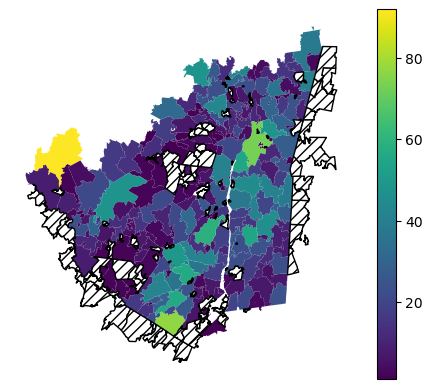

In [551]:
gdf_zipcodes.merge(zipcode2017_df.query("var_name == 'zipcode_var0'"), how="left", left_on='ZCTA5CE20', right_on = 'zip_5').plot(missing_kwds={'edgecolor': 'black', 'facecolor': 'white', 'hatch': '///'}, column='Value', legend=True).set_axis_off()

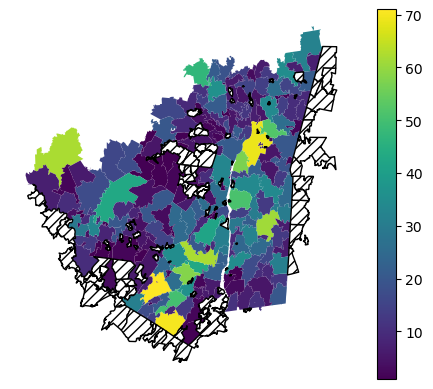

In [552]:
gdf_zipcodes.merge(zipcode2022_df.query("var_name == 'zipcode_var0'"), how="left", left_on='ZCTA5CE20', right_on = 'zip_5').plot(missing_kwds={'edgecolor': 'black', 'facecolor': 'white', 'hatch': '///'}, column='Value', legend=True).set_axis_off()

In [553]:
zipcode_vars_dict.get("zipcode_var0")

{'group_desc': 'INCOME',
 'commodity_desc': 'COMMODITY TOTALS',
 'class_desc': 'ALL CLASSES',
 'prodn_practice_desc': 'ALL PRODUCTION PRACTICES',
 'statisticcat_desc': 'SALES',
 'unit_desc': 'OPERATIONS',
 'domain_desc': 'TOTAL',
 'domaincat_desc': 'NOT SPECIFIED'}

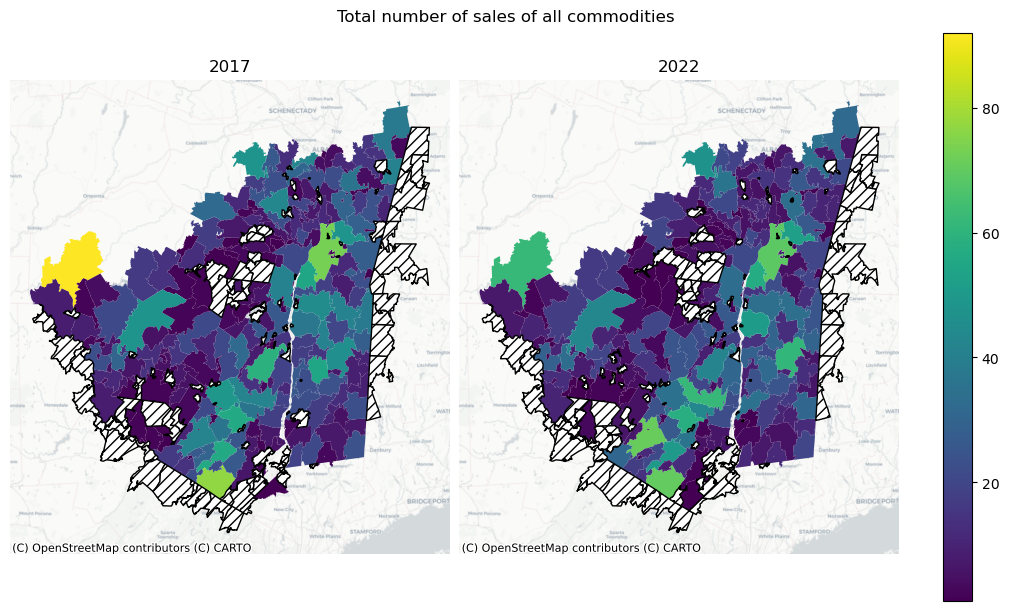

In [554]:
import matplotlib.pyplot as plt
import contextily as cx

vmax = max([zipcode2017_df.query("var_name == 'zipcode_var0'").Value.max(),zipcode2022_df.query("var_name == 'zipcode_var0'").Value.max()])
vmin = min([zipcode2017_df.query("var_name == 'zipcode_var0'").Value.min(),zipcode2022_df.query("var_name == 'zipcode_var0'").Value.min()])

fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(10,6))
gdf_zipcodes.merge(zipcode2017_df.query("var_name == 'zipcode_var0'"), how="left", left_on='ZCTA5CE20', right_on = 'zip_5') \
    .plot(ax=axs[0], vmin=vmin, vmax=vmax, missing_kwds={'edgecolor': 'black', 'facecolor': 'white', 'hatch': '///'}, column='Value').set_axis_off()
gdf_zipcodes.merge(zipcode2022_df.query("var_name == 'zipcode_var0'"), how="left", left_on='ZCTA5CE20', right_on = 'zip_5') \
    .plot(ax=axs[1], vmin=vmin, vmax=vmax, missing_kwds={'edgecolor': 'black', 'facecolor': 'white', 'hatch': '///'}, column='Value').set_axis_off()

axs[0].set_title("2017")
axs[1].set_title("2022")

for ax in axs:
    cx.add_basemap(ax=ax, crs=gdf_zipcodes.crs, source=cx.providers.CartoDB.Positron)

cbar = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='viridis')

fig.colorbar(cbar, ax=axs)
fig.suptitle("Total number of sales of all commodities");